In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from model import *
from pickle_cache import PickleCache
import pandas as pd
from experiment_widgets import VariableArithmeticMemoryExperiment
import json
from random import sample, randint, choices
import string
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

pcache = PickleCache()

In [48]:
all_names = string.ascii_lowercase
all_operators = ['+', '-']

def generate_trial(N):
    names = sample(all_names, k=N)
    variables = [
        {'variable': names[i], 'value': randint(1, 9)}
        for i in range(N)
    ]

    expr_var_order = sample(variables, k=len(variables))
    operators = choices(all_operators, k=N-1)
    expr_list = []
    expr_value = expr_var_order[0]['value']
    for i in range(N):
        if i > 0:
            op = operators[i-1]
            expr_value = eval(f"{expr_value} {op} {expr_var_order[i]['value']}")
            expr_list.append(op)
        expr_list.append(expr_var_order[i]['variable'])
    expr = ' '.join(expr_list)
    
    return {
        'variables': variables, 
        'expression': expr,
        'expression_value': expr_value,
        'presentation_time': 500 + N * 1500
    }

def exp_name(N_var, N_trials):
    return f'vararithmem_{N_var}_{N_trials}'

In [60]:
N_var = 5
N_trials = 10


experiment = {
    'trials': [generate_trial(N_var) for _ in range(N_trials)],
    'between_trials_time': 1000
}

exp = VariableArithmeticMemoryExperiment(experiment=json.dumps(experiment), results='[]')

def on_result_change(_):
    pcache.set(exp_name(N_var, N_trials), {
        'experiment': experiment,
        'results': json.loads(exp.results)
    })
    
exp.observe(on_result_change)

exp

VariableArithmeticMemoryExperiment(experiment='{"trials": [{"variables": [{"variable": "b", "value": 2}, {"var…

In [92]:
def process_results(N_var, N_trials):
    data = pcache.get(exp_name(N_var, N_trials))
    experiment = data['experiment']
    results = data['results']
    
    correct = 0
    for (trial, result) in zip(experiment['trials'], results):
        try:
            response = int(result['response'])
        except ValueError:
            continue
            
        if trial['expression_value'] == response:
            correct += 1

    return {
        'N_var': N_var,
        'Correct': correct / N_trials,
    }

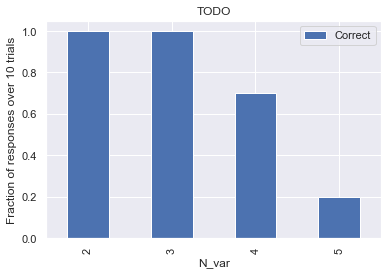

In [94]:
all_exp = [2, 3, 4, 5]
results = pd.DataFrame([process_results(N_var, 10) for N_var in all_exp])
results = results.set_index('N_var')
ax = results.plot.bar(title='TODO')
ax.set_ylabel('Fraction of responses over 10 trials')
plt.savefig('var_arith_mem.png', dpi=300)

In [71]:
results

,N_var,Correct,Wrong
0,2,1,0
1,2,1,0
2,2,1,0
3,2,1,0
4,2,1,0
5,2,1,0
6,2,1,0
7,2,1,0
8,2,1,0
9,2,1,0
